In [3]:
import math
import csv
import os
import numpy as np

import gurobipy as gp
from gurobipy import GRB
import time

import sys
import random
import copy

import itertools

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from joblib import Parallel, delayed

In [4]:
def plot_assignments_xy_from_x(s, x_sol, clientes, nome_figura=None):
    """
    s      = vetor binário (y[j]) indicando postos abertos
    x_sol  = matriz binária x[i][j] indicando que o cliente i é atendido pelo posto j
    clientes = lista de dicts {'x','y','demanda'}
    """

    # Extrair coordenadas
    xs = [c["x"] for c in clientes]
    ys = [c["y"] for c in clientes]

    N = len(clientes)

    # Postos abertos
    postos_abertos = [j for j in range(N) if s[j] > 0.5]

    # Construir vetor de atribuição a partir de x[i][j]
    atribuicao = [-1] * N
    for i in range(N):
        for j in range(N):
            if x_sol[i][j] > 0.5:
                atribuicao[i] = j
                break

    # Plot
    plt.figure(figsize=(8, 6))

    # Plotar clientes
    plt.scatter(xs, ys, marker='o', s=40, label="Clientes")

    # Nomear clientes
    for i in range(N):
        if i not in postos_abertos:
            plt.text(xs[i] + 0.02, ys[i] + 0.02,
                     str(i), fontsize=8, color="black",
                     ha='left', va='bottom')

    # Plotar postos abertos
    plt.scatter([xs[j] for j in postos_abertos],
                [ys[j] for j in postos_abertos],
                marker='o', s=150, edgecolors='black',
                facecolors='yellow', label="Postos abertos")

    # Números dos postos dentro dos pontos
    for j in postos_abertos:
        plt.text(xs[j], ys[j], str(j),
                 fontsize=7, color="black",
                 fontweight='bold', ha='center', va='center')

    # Plotar conexões cliente→posto
    for i, j in enumerate(atribuicao):
        if j != -1 and s[j] > 0.5:
            plt.plot([xs[i], xs[j]], [ys[i], ys[j]],
                     color="black", linewidth=0.4, alpha=0.3)

    plt.title("Atribuição de clientes usando solução Gurobi")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

    # Salvar figura se for solicitado
    if nome_figura is not None:
        plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
        
    plt.show()


# Funcao lê o arquivo e retorna uma lista de instâncias
def ler_pmedcap1(caminho_arquivo):
    problemas = []

    with open(caminho_arquivo, 'r') as f:
        linhas = [linha.strip() for linha in f if linha.strip()]

    M = int(linhas[0])
    idx = 1

    for _ in range(M):
        num_prob, best_value = map(int, linhas[idx].split())
        idx += 1

        n, p, Q = map(int, linhas[idx].split())
        idx += 1

        clientes = []
        for _ in range(n):
            partes = linhas[idx].split()
            cliente = int(partes[0])
            x = float(partes[1])
            y = float(partes[2])
            demanda = float(partes[3])
            clientes.append({"cliente": cliente, "x": x, "y": y, "demanda": demanda})
            idx += 1

        problemas.append({
            "id": num_prob,              # número do problema(instância)
            "best_value": best_value,    # melhor valor de solução encontrado
            "n": n,                      # quantidade de clintes
            "p": p,                      # numero de medianas a serem abertas
            "Q": Q,                      # capacidade dos postos
            "clientes": clientes         # dados dos clietes (coordenadas, demanda)
        })

    return problemas

# Função calcula as distancias entre cada cliente
def calcular_distancias(problemas):
    for problema in problemas:
        clientes = problema["clientes"]
        n = problema["n"]

        distancias = np.zeros((n, n))  # matriz inteira

        for i in range(n):
            for j in range(n):
                xi, yi = clientes[i]["x"], clientes[i]["y"]
                xj, yj = clientes[j]["x"], clientes[j]["y"]
                dist = math.sqrt((xi - xj)**2 + (yi - yj)**2)
                distancias[i, j] = int(dist) 
    
        problema["distancias"] = distancias


# Função resolve o modelo matemático da instância pelo GUROBI
def resolver_instancia(dados):
    melhor_valor = dados["best_value"]  # melhor valor de solução 
    n = dados["n"]                      # número de clientes
    p = dados["p"]                      # número de medianas para abrir
    Q = dados["Q"]                      # capacidade dos postos
    clientes = dados["clientes"]        # dados dos clientes
    d = dados["distancias"]    # matriz de distancias 

    # Vetor de demandas
    q = [c["demanda"] for c in clientes]

    # Definição de conjuntos
    N = n  # instância simétrica

    # Escrevendo o modelo do problema
    m = gp.Model("Problema_de_Localizacao_de_Facilidades")

    # Variáveis DE DECISÃO
    x = m.addVars(N, N, vtype=GRB.BINARY, name="x")   # alocação cliente i → posto j
    y = m.addVars(N, vtype=GRB.BINARY, name="y")      # 1 se posto j é aberto, 0 c.c.

    # Função objetivo: minimizar distância total
    m.setObjective(
        gp.quicksum(d[i, j] * x[i, j] for i in range(N) for j in range(N)),
        GRB.MINIMIZE
    )

    # Cada cliente deve ser atendido exatamente por um posto
    m.addConstrs(
        (gp.quicksum(x[i, j] for j in range(N)) == 1 for i in range(N)),
        name="ClientesAtendido"
    )

    # Número máximo de instalações abertas
    m.addConstr(
        gp.quicksum(y[j] for j in range(N)) == p,
        name="NumeroInstalacoes"
    )
    
    # Restrição de capacidade
    m.addConstrs(
        (gp.quicksum(q[i] * x[i, j] for i in range(N)) <= Q * y[j]
         for j in range(N)),
        name="CapacidadePosto"
    )

    # ajustando parÂmetros 
    m.setParam("OutputFlag", 0)      # não aparece as informações da iteração
    m.setParam("TimeLimit", 1800)    # limite de 30 minutos

    inicio = time.time()
    m.optimize()
    tempo_execucao = time.time() - inicio

    # armazenando os resultados
    solucao = {
        "Primal Bound": m.objVal,
        "Dual Bound": m.ObjBound,
        "Gap": m.MIPGap,
        "Tempo Execucao": tempo_execucao,
        "Solução OR-Library": melhor_valor,
        "Postos abertos": [j for j in range(N) if y[j].X > 0.5],
        "Vetor solução": [y[j].X for j in range(N)],
        "Matriz x": [[x[i, j].X for j in range(N)] for i in range(N)]
    }
    return solucao

In [7]:
# resolvendo as instancias
if __name__ == "__main__":
    arquivo = "Base de Dados/OR-Library/pmedcap1.txt"
    dados = ler_pmedcap1(arquivo)
    calcular_distancias(dados)

    print(f"Total de instâncias: {len(dados)}\n")

    solutions = []
    # for i in range(len(dados)):
    for i in range(0,20):
        print(f"---Resolvendo instância {i+1}---")
        resultado = resolver_instancia(dados[i])
        clientes = dados[i]["clientes"]
        solutions.append(resultado)
        

        c = 0
        for k in range(len(clientes)):
            c += clientes[k]["demanda"]
        print("\nDemanda dos clientes:", c)
        
        print("Capacidade dos postos:", dados[i]["Q"])
        
        dimensao = dados[i]
        N = dimensao['n']
        print("N =", N, "\n")

        print(f"Tempo de Execução: {resultado['Tempo Execucao']:.2f} s")
        print(f"Ótimo Gurobi: {resultado['Primal Bound']:.2f}")
        print(f"Ótimo OR-Library: {resultado['Solução OR-Library']}")
        print(f"Gap: {resultado['Gap']:.2%}")
        print(f"Postos abertos: {resultado['Postos abertos']}\n")
         
        s = resultado['Vetor solução']
        x_sol = resultado['Matriz x']
        
        # Plotar
        # plot_assignments_xy_from_x(s, x_sol, clientes, nome_figura=f"gurobi{i+1}.png")

Total de instâncias: 20

---Resolvendo instância 1---

Demanda dos clientes: 490.0
Capacidade dos postos: 120
N = 50 

Tempo de Execução: 1.40 s
Ótimo Gurobi: 713.00
Ótimo OR-Library: 713
Gap: 0.00%
Postos abertos: [9, 11, 18, 20, 47]

---Resolvendo instância 2---

Demanda dos clientes: 502.0
Capacidade dos postos: 120
N = 50 

Tempo de Execução: 0.38 s
Ótimo Gurobi: 740.00
Ótimo OR-Library: 740
Gap: 0.00%
Postos abertos: [15, 21, 25, 32, 46]

---Resolvendo instância 3---

Demanda dos clientes: 512.0
Capacidade dos postos: 120
N = 50 

Tempo de Execução: 0.55 s
Ótimo Gurobi: 751.00
Ótimo OR-Library: 751
Gap: 0.00%
Postos abertos: [14, 19, 37, 38, 47]

---Resolvendo instância 4---

Demanda dos clientes: 517.0
Capacidade dos postos: 120
N = 50 

Tempo de Execução: 0.40 s
Ótimo Gurobi: 651.00
Ótimo OR-Library: 651
Gap: 0.00%
Postos abertos: [2, 8, 28, 42, 49]

---Resolvendo instância 5---

Demanda dos clientes: 541.0
Capacidade dos postos: 120
N = 50 

Tempo de Execução: 0.76 s
Ótimo Guro

In [ ]:
solucoes_otimas = [713, 740, 751, 651, 664, 778, 787, 820, 715, 829, 1006, 966, 1026, 982, 1091, 954, 1034, 1043, 1031, 1005]

## VND

In [6]:
# def plot_assignments_xy(s, atribuicao, clientes):
def plot_assignments_xy(s, atribuicao, clientes, nome_figura=None):
    """
    s = vetor binário indicando quais postos estão abertos
    atribuicao[i] = posto j que atende o cliente i
    clientes = lista com {'x', 'y', 'demanda'}
    """

    x = [c["x"] for c in clientes]
    y = [c["y"] for c in clientes]

    postos_abertos = [j for j in range(len(s)) if s[j] > 0.5]

    plt.figure(figsize=(8, 6))

    # Plot clientes
    plt.scatter(x, y, marker='o', s=40, label="Clientes")

    # Nome dos clientes (exceto os postos) ao lado do ponto
    for i in range(len(clientes)):
        if i not in postos_abertos:
            plt.text(x[i] + 0.02, y[i] + 0.02,
                     str(i),
                     fontsize=8, color="black",
                     ha='left', va='bottom')

    # Plot postos abertos
    plt.scatter([x[j] for j in postos_abertos],
                [y[j] for j in postos_abertos],
                marker='o', s=150, edgecolors='black',
                facecolors='yellow', label="Postos abertos")

    # Escrever número do posto DENTRO do quadrado
    for j in postos_abertos:
        plt.text(x[j], y[j], str(j),
                 fontsize=7, color="black",
                 fontweight='bold',
                 ha='center', va='center')

    # Conexões cliente → posto
    for i, j in enumerate(atribuicao):
        if j != -1 and s[j] > 0.5:
            plt.plot([x[i], x[j]], [y[i], y[j]], color="black", linewidth=0.4, alpha=0.3)

    plt.title("Atribuição de clientes aos postos")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
    # Salvar figura se for solicitado
    if nome_figura is not None:
        plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    
    plt.show()

def atribuir_clientes_capacitado(s, d, q, Q, tentativas=10):
    s = np.array(s)
    d = np.array(d)
    q = np.array(q)

    abertas = np.where(s == 1)[0]
    if len(abertas) == 0:
        return None, False

    n_clientes = d.shape[0]
    # distâncias apenas para postos abertos
    d_sub = d[:, abertas]

    # ordena postos abertos por distância para cada cliente
    ordem_postos = np.argsort(d_sub, axis=1)

    for _ in range(tentativas):
        ordem_clientes = np.random.permutation(n_clientes)
        cap_rest = {j: Q for j in abertas}  # capacidade de cada posto aberto
        atribuicao = np.full(n_clientes, -1, dtype=int)
        viavel = True

        for i in ordem_clientes:
            demanda = q[i]
            # percorre postos abertos em ordem de distância
            for pos in ordem_postos[i]:
                j = abertas[pos]  # índice real do posto
                if cap_rest[j] >= demanda:
                    atribuicao[i] = j
                    cap_rest[j] -= demanda
                    break
            if atribuicao[i] == -1:  # cliente não alocado
                viavel = False
                break

        if viavel:
            return atribuicao.tolist(), True  # alocação viável encontrada

    return None, False  # nenhuma atribuição viável após as tentativas


    
def atribuicao_exata(d, q, Q, postos_abertos):
    M = d.shape[0]          # número de clientes
    A = len(postos_abertos) # número de postos abertos

    try:
        model = gp.Model("Atribuicao_Exata")
        model.setParam('OutputFlag', 0)

        # Variáveis x[i,jj] = 1 se cliente i for atendido pelo posto aberto jj
        x = model.addVars(
            M, A,
            vtype=GRB.BINARY,
            name="x"
        )

        # Cada cliente deve ser atendido por um único posto
        for i in range(M):
            model.addConstr(gp.quicksum(x[i, jj] for jj in range(A)) == 1)

        # Respeitar capacidades dos postos abertos
        for jj, j in enumerate(postos_abertos):
            model.addConstr(
                gp.quicksum(q[i] * x[i, jj] for i in range(M)) <= Q
            )

        # Função objetivo
        model.setObjective(
            gp.quicksum(d[i][postos_abertos[jj]] * x[i, jj] for i in range(M) for jj in range(A)),
            GRB.MINIMIZE
        )

        model.optimize()

        if model.Status != GRB.OPTIMAL:
            print("-------- GUROBI NÃO ENCONTROU SOLUÇÃO ÓTIMA --------")
            return None, None

        # extrair solução
        atribuicao = [-1] * M
        for i in range(M):
            for jj in range(A):
                if x[i, jj].X > 0.5:
                    atribuicao[i] = postos_abertos[jj]

        custo_total = model.ObjVal
        return atribuicao, custo_total

    except gp.GurobiError as e:
        print("Erro Gurobi:", e)
        return None, None

        
def metodo_guloso_capacitado(n, P, d, q, Q):
    q = np.array(q)

    if d.ndim == 1:
        raise ValueError("A matriz de distâncias 'd' deve ser (n x n).")
    if d.shape[0] != n or d.shape[1] != n:
        raise ValueError(f"Matriz de distâncias deve ser {n}x{n}, mas tem {d.shape}.")
    if len(q) != n:
        raise ValueError(f"Vetor de demandas 'q' deve ter {n} elementos.")

    abertos = []
    restantes = set(range(n))
    custo_cliente = np.full(n, np.inf)  # custo mínimo atual de cada cliente
    atribuicao_atual = np.full(n, -1)   # posto atual de cada cliente
    cap_rest = {}                       # capacidade restante por posto aberto

    # --- Processo guloso ---
    for _ in range(P):
        melhor_post = None
        melhor_melhoria = -np.inf
        melhor_nova_atribuicao = None
        melhor_nova_cap = None

        for j in list(restantes):
            economia = custo_cliente - d[:, j]
            clientes_com_ganho = np.where(economia > 0)[0]
            if clientes_com_ganho.size == 0:
                economia_total = 0.0
            else:
                # Ordena clientes por maior economia
                ordenados = sorted(clientes_com_ganho, key=lambda i: economia[i], reverse=True)
                cap = Q
                economia_total = 0.0
                selecionados = []
                for i in ordenados:
                    if q[i] <= cap:
                        selecionados.append(i)
                        cap -= q[i]
                        economia_total += economia[i]

            # Guarda se este posto é o melhor até agora
            if economia_total > melhor_melhoria:
                custo_novo = custo_cliente.copy()
                nova_atr = atribuicao_atual.copy()
                nova_cap = cap_rest.copy()

                # Aloca os clientes que foram selecionados
                if economia_total > 0:
                    cap = Q
                    for i in sorted(clientes_com_ganho, key=lambda i: economia[i], reverse=True):
                        if q[i] <= cap and economia[i] > 0:
                            if nova_atr[i] != -1:
                                # devolver capacidade anterior
                                k_antigo = nova_atr[i]
                                nova_cap[k_antigo] += q[i]
                            nova_atr[i] = j
                            custo_novo[i] = d[i, j]
                            cap -= q[i]
                    nova_cap[j] = cap
                else:
                    nova_cap[j] = Q

                melhor_post = j
                melhor_melhoria = economia_total
                melhor_nova_atribuicao = nova_atr
                melhor_nova_cap = nova_cap

        # Caso nenhuma melhoria seja encontrada
        if melhor_post is None:
            if not restantes:
                break
            j = restantes.pop()
            abertos.append(j)
            cap_rest[j] = Q
        else:
            abertos.append(melhor_post)
            restantes.remove(melhor_post)
            atribuicao_atual = melhor_nova_atribuicao
            cap_rest = melhor_nova_cap
            custo_cliente = np.array([
                d[i, atribuicao_atual[i]] if atribuicao_atual[i] != -1 else np.inf
                for i in range(n)
            ])

    # montendo o vetor binário de postos abertos
    s0 = [1 if j in abertos else 0 for j in range(n)]

    # garante atribuição factível final
    atrib, feasible = atribuir_clientes_capacitado(s0, d, q, Q)
    if not feasible:
        print("Atribuição final inviável")

    return s0
    

# Vizinhanca swap com capacidade
def vizinhanca_v1(y_, d, q, Q, coords):
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]

    for i in abertos:
        for j in fechados:
            novo = y_.copy()
            novo[i], novo[j] = 0, 1

            vizinhos.append(novo)

    return vizinhos

# Vizinhança olha posições antecessora e sucessora da solução para possível troca
def vizinhanca_v2(y_, d, q, Q, coords):
    vizinhos = []
    n = len(y_)
    
    for i in range(n):
        # Tenta trocar com a posição anterior
        if i > 0 and y_[i] != y_[i - 1]:
            novo = y_.copy()
            novo[i], novo[i - 1] = novo[i - 1], novo[i]

            vizinhos.append(novo)
                
        # Se não puder trocar com anterior, tenta sucessor
        elif i < n - 1 and y_[i] != y_[i + 1]:
            novo = y_.copy()
            novo[i], novo[i + 1] = novo[i + 1], novo[i]

            vizinhos.append(novo)
                
        # Caso contrário, não adiciona vizinho

    return vizinhos


# troca k postos abertos por k postos fechados
def vizinhanca_v3(y_, d, q, Q, coords):
    k = 2 # 2 é o número máximo para que computacionalmente seja possível executar o código
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]

    # se não houver pares suficientes, não gera nada
    if len(abertos) < k or len(fechados) < k:
        return vizinhos

    # todas as combinações de k abertos e k fechados
    for abertos_remover in itertools.combinations(abertos, k):
        for fechados_adicionar in itertools.combinations(fechados, k):
            novo = y_.copy()
            # fecha os escolhidos
            for i in abertos_remover:
                novo[i] = 0
            # abre os escolhidos
            for j in fechados_adicionar:
                novo[j] = 1

            vizinhos.append(novo)

    return vizinhos

# vizinhanca troca o primeiro posto aberto pelos len(y_)/sum(y_) ultimos postos fechados
def vizinhanca_v5(y_, d, q, Q, coords):
    vizinhos = []
    primeiro_aberto = next((i for i, val in enumerate(y_) if val == 1), None)
    
    if primeiro_aberto is None:
        return []  # Não há postos abertos para trocar

    for j in reversed(range(len(y_))):
        if y_[j] == 0:
            novo = y_.copy()
            novo[primeiro_aberto] = 0
            novo[j] = 1

            vizinhos.append(novo)

    return vizinhos
    
# Vizinhança troca postos abertos com um posto fechado que esteja dentro de um raio 
def vizinhanca_v6(y_, d, q, Q, coords, raio = 20):
    y_ = np.array(y_)
    coords = np.array(coords)
    n = len(y_)

    abertas = np.where(y_ == 1)[0]
    fechadas = np.where(y_ == 0)[0]

    vizinhos = []

    # Para cada posto aberto
    for j_aberta in abertas:
        x1, y1 = coords[j_aberta]

        # Procura postos fechados próximos
        for j_fechada in fechadas:
            x2, y2 = coords[j_fechada]

            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

            # Se está dentro do raio, gera vizinho
            if dist <= raio:
                v = y_.copy()
                v[j_aberta] = 0
                v[j_fechada] = 1
                vizinhos.append(v)
                postos_abertos = [j for j in range(len(y_)) if v[j] > 0.5]            
                # print(postos_abertos)
                
    return vizinhos

def coordenadas(problema):
    clientes = problema["clientes"]
    
    # extrai pares (x,y)
    coords = [(c["x"], c["y"]) for c in clientes]

    # converte para array 2D garantido
    return np.array(coords, dtype=float).reshape(-1, 2)

    
def f(s, d, q, Q):
    s = np.array(s)
    
    abertas = np.where(s == 1)[0]
    if len(abertas) == 0:
        return np.inf # penaliza as soluções infactíveis

    n_clientes = d.shape[0]
    atribuicao = np.full(n_clientes, -1, dtype=int)
    capacidade_restante = {j: Q for j in abertas}  #  usa índices reais dos postos

    # custo marginal
    dist_ordenadas = np.sort(d[:, abertas], axis=1)
    regret = dist_ordenadas[:,1] - dist_ordenadas[:,0]
    ordem_clientes = np.argsort(-regret)  # maior regret primeiro

    # aloca cada cliente no posto mais próximo possível com capacidade disponível
    for i in ordem_clientes:
        candidatos = sorted(abertas, key=lambda j: d[i,j])
        for j in candidatos:
            if capacidade_restante[j] >= q[i]:
                atribuicao[i] = j
                capacidade_restante[j] -= q[i]
                break

    # se algum cliente não foi atendido, a solução é inviável
    if np.any(atribuicao == -1):
        return np.inf

    # soma das distâncias dos clientes aos postos atribuídos
    custo_total = np.sum(d[np.arange(n_clientes), atribuicao])
    
    return custo_total


def VND(s0, vizinhancas, d, q, Q, M, N, P, coords):
    tempo_max = 3600
    tempo_limite_vizinhanca = 900
    s = s0
    f_s = f(s, d, q, Q)
    print(f"Valor da função objetivo com a Solucao Inicial: {f_s}")
    k = 0
    num_solucoes = 0
    postos = []

    inicio = time.time()
    while k < len(vizinhancas) and (time.time() - inicio) < tempo_max:
        start_time = time.time()

        vizinhos = vizinhancas[k](s, d, q, Q, coords)
        print(f"Tamanho da vizinhança {k}: {len(vizinhos)}")
            
        valores = Parallel(n_jobs=-1)(
            delayed(f)(v, d, q, Q) for v in vizinhos
        )

        idx_min = np.argmin(valores)
        f_melhor = valores[idx_min]
        melhor = vizinhos[idx_min]

        if f_melhor < f_s:
            s = melhor
            f_s = f_melhor
            print(f"Melhoria encontrada na vizinhança {k}: Novo custo: {f_s}")
            k = 0
            num_solucoes += 1
            postos_abertos = [j for j in range(N) if s[j] > 0.5]
            postos.append(postos_abertos)
        else:
            k += 1

        if time.time() - start_time > tempo_limite_vizinhanca:
            print(f"Tempo excedido na vizinhança {k}")
            break

    print('Número de soluções novas encontradas: ', num_solucoes)

    # Método exato final com Gurobi
    atribuicao, f_s = atribuicao_exata(d, q, Q, postos_abertos)

    return s, f_s, atribuicao

Total de instâncias: 20

---Resolvendo instância 1---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 828.0
Tamanho da vizinhança 0: 2
Tamanho da vizinhança 1: 30
Melhoria encontrada na vizinhança 1: Novo custo: 801.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 31
Melhoria encontrada na vizinhança 1: Novo custo: 779.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 32
Melhoria encontrada na vizinhança 1: Novo custo: 764.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 33
Melhoria encontrada na vizinhança 1: Novo custo: 754.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 33
Melhoria encontrada na vizinhança 1: Novo custo: 749.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 33
Melhoria encontrada na vizinhança 1: Novo custo: 746.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 32
Tamanho da vizinhança 2: 225
Melhoria encontrada na vizinhança 2: Novo custo: 743.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1

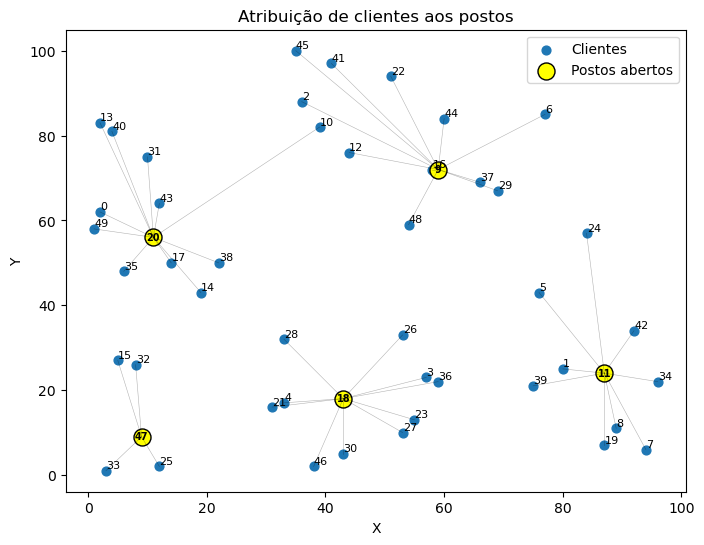




---Resolvendo instância 2---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1719.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1184.0
Tamanho da vizinhança 0: 4
Melhoria encontrada na vizinhança 0: Novo custo: 1106.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 17
Melhoria encontrada na vizinhança 1: Novo custo: 1059.0
Tamanho da vizinhança 0: 10
Melhoria encontrada na vizinhança 0: Novo custo: 956.0
Tamanho da vizinhança 0: 10
Melhoria encontrada na vizinhança 0: Novo custo: 897.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 27
Melhoria encontrada na vizinhança 1: Novo custo: 875.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 29
Melhoria encontrada na vizinhança 1: Novo custo: 844.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 30
Melhoria encontrada na vizinhança 1: Novo custo: 820.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 28
Melhoria encontrada na vizinhança 1: Novo cus

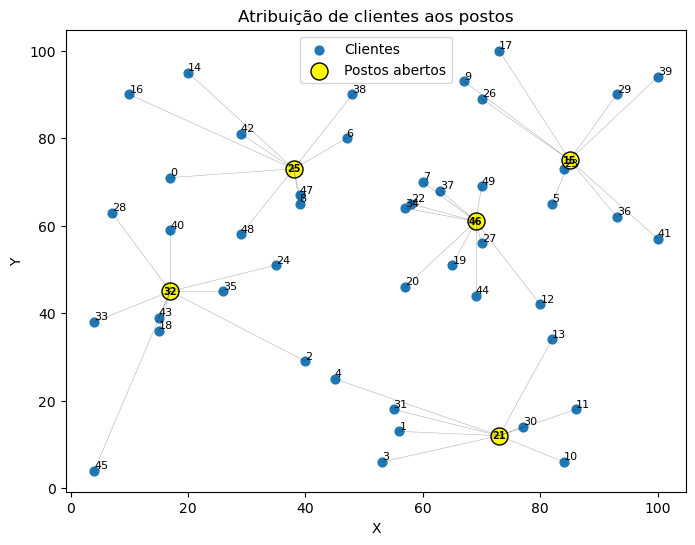




---Resolvendo instância 3---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1320.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1166.0
Tamanho da vizinhança 0: 4
Melhoria encontrada na vizinhança 0: Novo custo: 1087.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 22
Melhoria encontrada na vizinhança 1: Novo custo: 970.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 24
Melhoria encontrada na vizinhança 1: Novo custo: 931.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 24
Melhoria encontrada na vizinhança 1: Novo custo: 912.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 24
Melhoria encontrada na vizinhança 1: Novo custo: 894.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 25
Melhoria encontrada na vizinhança 1: Novo custo: 889.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 25
Melhoria encontrada na vizinhança 1: Novo custo: 879.0
Tamanho da vizinhança 0: 15
Tamanho da vizinh

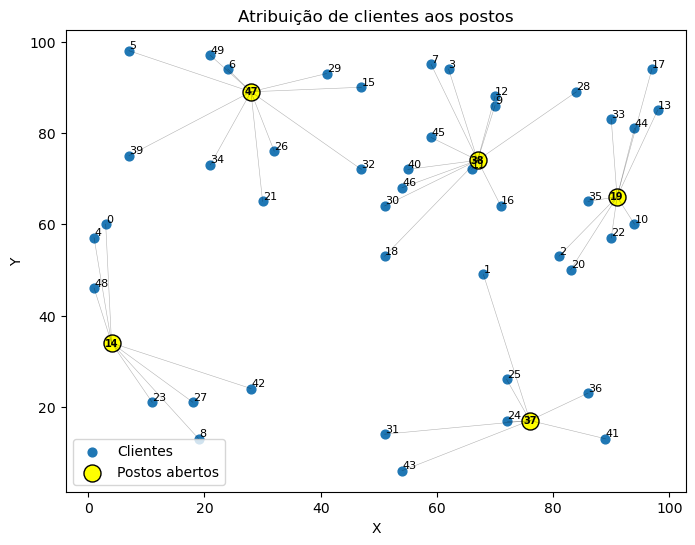




---Resolvendo instância 4---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1197.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1094.0
Tamanho da vizinhança 0: 4
Tamanho da vizinhança 1: 25
Melhoria encontrada na vizinhança 1: Novo custo: 1054.0
Tamanho da vizinhança 0: 10
Melhoria encontrada na vizinhança 0: Novo custo: 924.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 33
Melhoria encontrada na vizinhança 1: Novo custo: 877.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 35
Melhoria encontrada na vizinhança 1: Novo custo: 834.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 36
Melhoria encontrada na vizinhança 1: Novo custo: 820.0
Tamanho da vizinhança 0: 15
Tamanho da vizinhança 1: 33
Tamanho da vizinhança 2: 225
Melhoria encontrada na vizinhança 2: Novo custo: 652.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 37
Tamanho da vizinhança 2: 225
Tamanho da vizinhança 3: 9900
Número de 

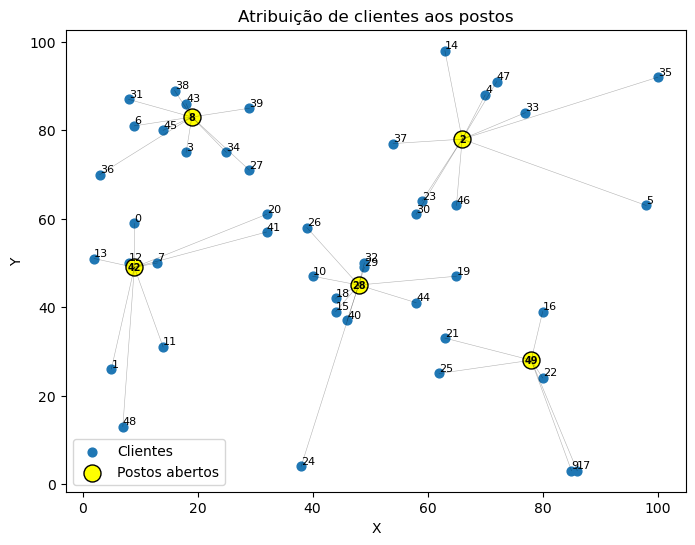




---Resolvendo instância 5---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1234.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1233.0
Tamanho da vizinhança 0: 4
Melhoria encontrada na vizinhança 0: Novo custo: 975.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 25
Melhoria encontrada na vizinhança 1: Novo custo: 868.0
Tamanho da vizinhança 0: 9
Tamanho da vizinhança 1: 29
Melhoria encontrada na vizinhança 1: Novo custo: 813.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 32
Melhoria encontrada na vizinhança 1: Novo custo: 775.0
Tamanho da vizinhança 0: 14
Melhoria encontrada na vizinhança 0: Novo custo: 742.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 35
Melhoria encontrada na vizinhança 1: Novo custo: 681.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 34
Melhoria encontrada na vizinhança 1: Novo custo: 672.0
Tamanho da vizinhança 0: 15
Tamanho da vizinhança 1: 35
Tamanho da vizinha

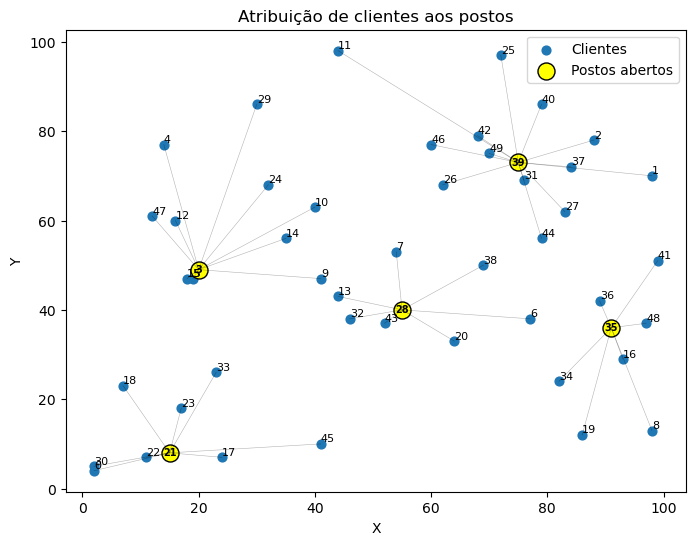




---Resolvendo instância 6---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1165.0
Tamanho da vizinhança 0: 2
Tamanho da vizinhança 1: 17
Melhoria encontrada na vizinhança 1: Novo custo: 1099.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 18
Melhoria encontrada na vizinhança 1: Novo custo: 1050.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 19
Melhoria encontrada na vizinhança 1: Novo custo: 1026.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 19
Melhoria encontrada na vizinhança 1: Novo custo: 1017.0
Tamanho da vizinhança 0: 14
Melhoria encontrada na vizinhança 0: Novo custo: 960.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 25
Melhoria encontrada na vizinhança 1: Novo custo: 930.0
Tamanho da vizinhança 0: 13
Melhoria encontrada na vizinhança 0: Novo custo: 924.0
Tamanho da vizinhança 0: 13
Melhoria encontrada na vizinhança 0: Novo custo: 902.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 21
Melhoria encon

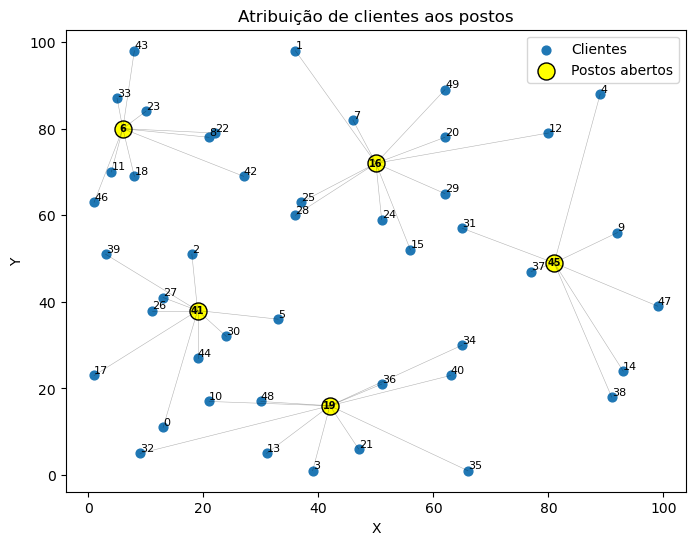




---Resolvendo instância 7---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1087.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 972.0
Tamanho da vizinhança 0: 4
Tamanho da vizinhança 1: 28
Melhoria encontrada na vizinhança 1: Novo custo: 939.0
Tamanho da vizinhança 0: 9
Tamanho da vizinhança 1: 28
Melhoria encontrada na vizinhança 1: Novo custo: 920.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 31
Melhoria encontrada na vizinhança 1: Novo custo: 912.0
Tamanho da vizinhança 0: 15
Tamanho da vizinhança 1: 31
Melhoria encontrada na vizinhança 1: Novo custo: 908.0
Tamanho da vizinhança 0: 15
Melhoria encontrada na vizinhança 0: Novo custo: 895.0
Tamanho da vizinhança 0: 15
Tamanho da vizinhança 1: 32
Melhoria encontrada na vizinhança 1: Novo custo: 891.0
Tamanho da vizinhança 0: 15
Tamanho da vizinhança 1: 33
Melhoria encontrada na vizinhança 1: Novo custo: 889.0
Tamanho da vizinhança 0: 13
Tamanho da vizinha

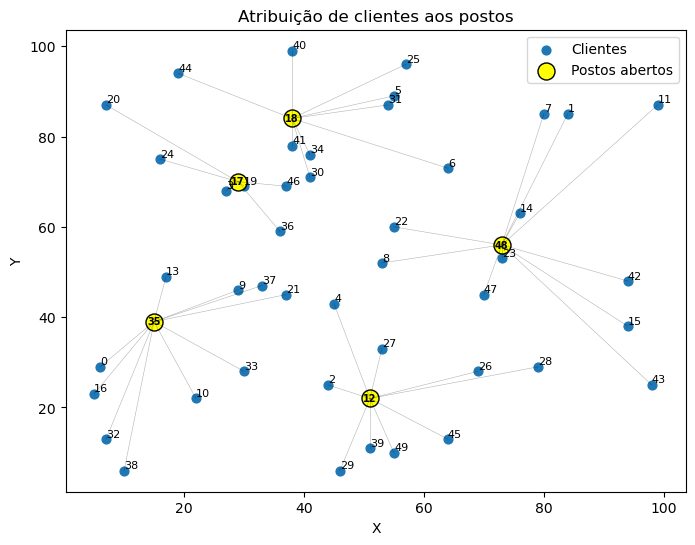




---Resolvendo instância 8---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1239.0
Tamanho da vizinhança 0: 2
Tamanho da vizinhança 1: 17
Melhoria encontrada na vizinhança 1: Novo custo: 1163.0
Tamanho da vizinhança 0: 7
Melhoria encontrada na vizinhança 0: Novo custo: 923.0
Tamanho da vizinhança 0: 7
Tamanho da vizinhança 1: 22
Melhoria encontrada na vizinhança 1: Novo custo: 902.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 22
Melhoria encontrada na vizinhança 1: Novo custo: 886.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 23
Melhoria encontrada na vizinhança 1: Novo custo: 839.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 27
Melhoria encontrada na vizinhança 1: Novo custo: 830.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 24
Melhoria encontrada na vizinhança 1: Novo custo: 828.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 24
Melhoria encontrada na vizinhança 1: Novo custo: 827.0
Tamanho da vizinh

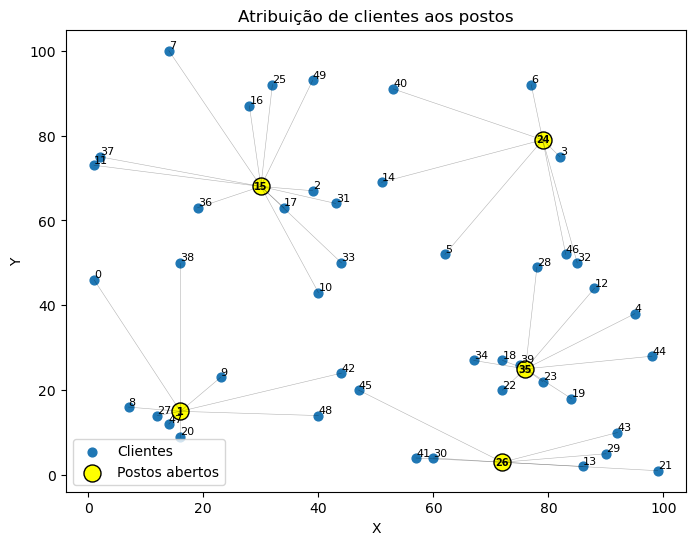




---Resolvendo instância 9---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1045.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1008.0
Tamanho da vizinhança 0: 4
Tamanho da vizinhança 1: 29
Melhoria encontrada na vizinhança 1: Novo custo: 892.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 27
Melhoria encontrada na vizinhança 1: Novo custo: 844.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 28
Melhoria encontrada na vizinhança 1: Novo custo: 764.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 31
Melhoria encontrada na vizinhança 1: Novo custo: 748.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 32
Melhoria encontrada na vizinhança 1: Novo custo: 739.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 35
Melhoria encontrada na vizinhança 1: Novo custo: 723.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 38
Melhoria encontrada na vizinhança 1: Novo custo: 715.0
Tamanho da vizin

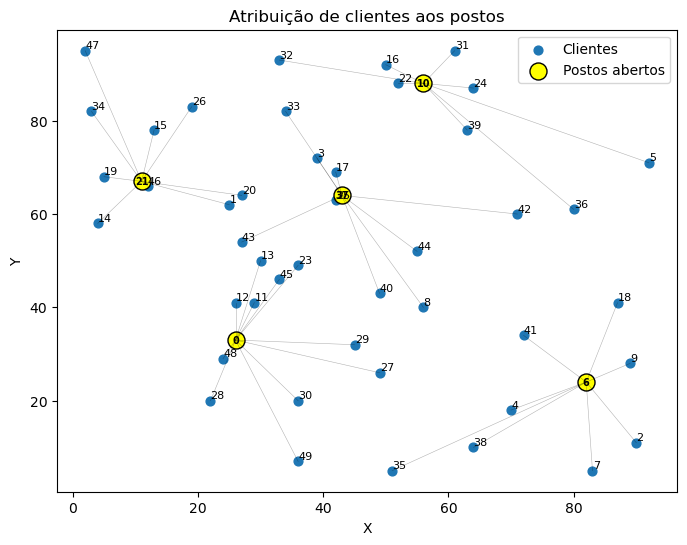




---Resolvendo instância 10---
Fornecedores inicial: [0, 1, 2, 3, 4]
Valor da função objetivo com a Solucao Inicial: 1251.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 1182.0
Tamanho da vizinhança 0: 4
Tamanho da vizinhança 1: 23
Melhoria encontrada na vizinhança 1: Novo custo: 1005.0
Tamanho da vizinhança 0: 8
Melhoria encontrada na vizinhança 0: Novo custo: 974.0
Tamanho da vizinhança 0: 7
Melhoria encontrada na vizinhança 0: Novo custo: 964.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 27
Melhoria encontrada na vizinhança 1: Novo custo: 918.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 28
Melhoria encontrada na vizinhança 1: Novo custo: 898.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 30
Melhoria encontrada na vizinhança 1: Novo custo: 885.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 31
Tamanho da vizinhança 2: 225
Melhoria encontrada na vizinhança 2: Novo custo: 880.0
Tamanho da vizinhança 0: 13
Tamanho da vizin

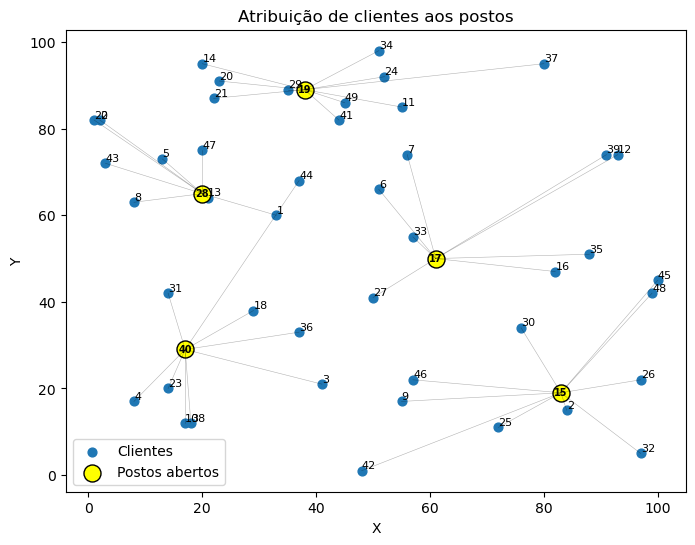




---Resolvendo instância 11---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 57]
Valor da função objetivo com a Solucao Inicial: 1875.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1740.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 87
Melhoria encontrada na vizinhança 1: Novo custo: 1622.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 83
Melhoria encontrada na vizinhança 1: Novo custo: 1527.0
Tamanho da vizinhança 0: 16
Melhoria encontrada na vizinhança 0: Novo custo: 1506.0
Tamanho da vizinhança 0: 17
Melhoria encontrada na vizinhança 0: Novo custo: 1420.0
Tamanho da vizinhança 0: 17
Melhoria encontrada na vizinhança 0: Novo custo: 1415.0
Tamanho da vizinhança 0: 17
Melhoria encontrada na vizinhança 0: Novo custo: 1346.0
Tamanho da vizinhança 0: 16
Tamanho da vizinhança 1: 101
Melhoria encontrada na vizinhança 1: Novo custo: 1280.0
Tamanho da vizinhança 0: 16
Tamanho da vizinhança 1: 103
Melhoria encontrada na vizinhança 1: Novo cust

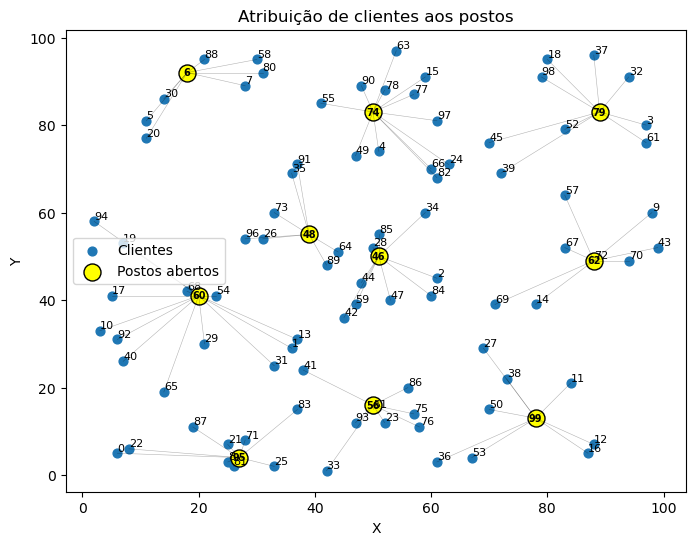




---Resolvendo instância 12---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 70]
Valor da função objetivo com a Solucao Inicial: 1409.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 111
Melhoria encontrada na vizinhança 1: Novo custo: 1314.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 118
Melhoria encontrada na vizinhança 1: Novo custo: 1242.0
Tamanho da vizinhança 0: 16
Melhoria encontrada na vizinhança 0: Novo custo: 1229.0
Tamanho da vizinhança 0: 17
Melhoria encontrada na vizinhança 0: Novo custo: 1216.0
Tamanho da vizinhança 0: 17
Tamanho da vizinhança 1: 123
Melhoria encontrada na vizinhança 1: Novo custo: 1188.0
Tamanho da vizinhança 0: 19
Tamanho da vizinhança 1: 122
Melhoria encontrada na vizinhança 1: Novo custo: 1164.0
Tamanho da vizinhança 0: 19
Tamanho da vizinhança 1: 124
Melhoria encontrada na vizinhança 1: Novo custo: 1146.0
Tamanho da vizinhança 0: 23
Tamanho da vizinhança 1: 119
Melhoria encontrada na vizinhança 1: Novo custo: 1137.0
Tamanho da vi

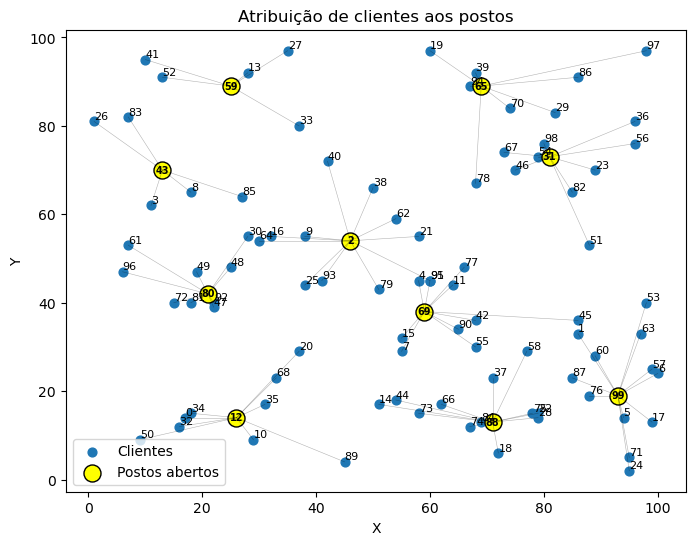




---Resolvendo instância 13---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 15]
Valor da função objetivo com a Solucao Inicial: 1788.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1768.0
Tamanho da vizinhança 0: 7
Melhoria encontrada na vizinhança 0: Novo custo: 1671.0
Tamanho da vizinhança 0: 8
Melhoria encontrada na vizinhança 0: Novo custo: 1591.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 94
Melhoria encontrada na vizinhança 1: Novo custo: 1441.0
Tamanho da vizinhança 0: 14
Melhoria encontrada na vizinhança 0: Novo custo: 1401.0
Tamanho da vizinhança 0: 14
Tamanho da vizinhança 1: 105
Melhoria encontrada na vizinhança 1: Novo custo: 1280.0
Tamanho da vizinhança 0: 18
Tamanho da vizinhança 1: 107
Melhoria encontrada na vizinhança 1: Novo custo: 1218.0
Tamanho da vizinhança 0: 18
Tamanho da vizinhança 1: 106
Melhoria encontrada na vizinhança 1: Novo custo: 1181.0
Tamanho da vizinhança 0: 23
Melhoria encontrada na vizinhança 0: Novo custo

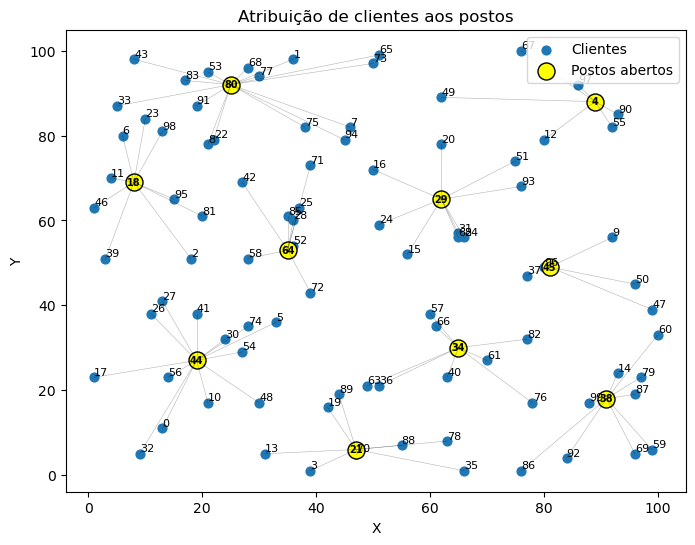




---Resolvendo instância 16---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 61]
Valor da função objetivo com a Solucao Inicial: 1693.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1452.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1434.0
Tamanho da vizinhança 0: 7
Melhoria encontrada na vizinhança 0: Novo custo: 1297.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 122
Melhoria encontrada na vizinhança 1: Novo custo: 1217.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 122
Melhoria encontrada na vizinhança 1: Novo custo: 1146.0
Tamanho da vizinhança 0: 18
Tamanho da vizinhança 1: 122
Melhoria encontrada na vizinhança 1: Novo custo: 1111.0
Tamanho da vizinhança 0: 22
Tamanho da vizinhança 1: 127
Melhoria encontrada na vizinhança 1: Novo custo: 1065.0
Tamanho da vizinhança 0: 26
Tamanho da vizinhança 1: 131
Melhoria encontrada na vizinhança 1: Novo custo: 1036.0
Tamanho da vizinhança 0: 25
Tamanho da vizinh

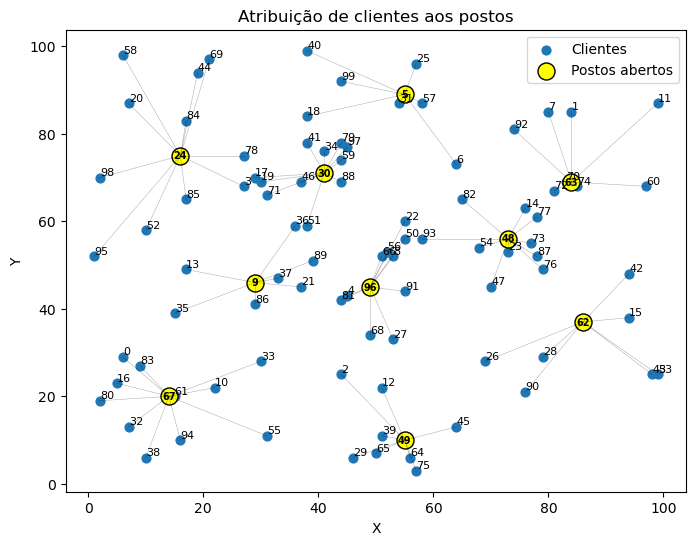




---Resolvendo instância 17---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 96]
Valor da função objetivo com a Solucao Inicial: 1732.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1614.0
Tamanho da vizinhança 0: 7
Melhoria encontrada na vizinhança 0: Novo custo: 1541.0
Tamanho da vizinhança 0: 8
Melhoria encontrada na vizinhança 0: Novo custo: 1450.0
Tamanho da vizinhança 0: 9
Melhoria encontrada na vizinhança 0: Novo custo: 1369.0
Tamanho da vizinhança 0: 9
Melhoria encontrada na vizinhança 0: Novo custo: 1367.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 102
Melhoria encontrada na vizinhança 1: Novo custo: 1259.0
Tamanho da vizinhança 0: 16
Tamanho da vizinhança 1: 108
Melhoria encontrada na vizinhança 1: Novo custo: 1204.0
Tamanho da vizinhança 0: 21
Tamanho da vizinhança 1: 111
Melhoria encontrada na vizinhança 1: Novo custo: 1164.0
Tamanho da vizinhança 0: 21
Tamanho da vizinhança 1: 114
Melhoria encontrada na vizinhança 1: Novo custo

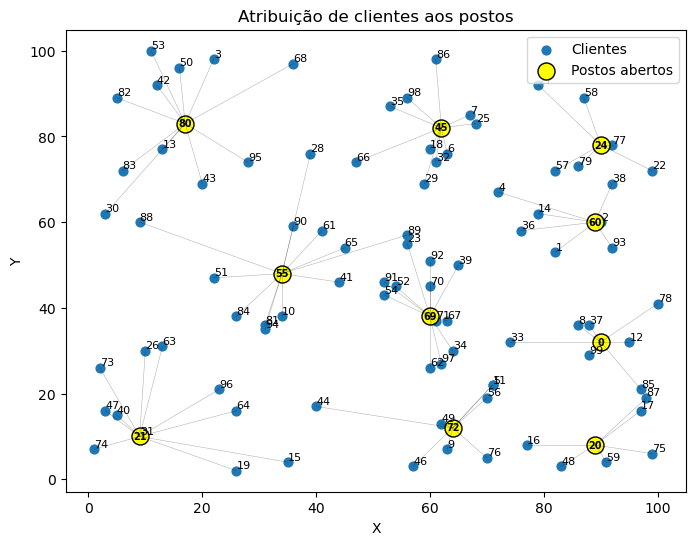




---Resolvendo instância 18---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 74]
Valor da função objetivo com a Solucao Inicial: 2051.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 83
Melhoria encontrada na vizinhança 1: Novo custo: 1858.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 78
Melhoria encontrada na vizinhança 1: Novo custo: 1680.0
Tamanho da vizinhança 0: 11
Tamanho da vizinhança 1: 85
Melhoria encontrada na vizinhança 1: Novo custo: 1596.0
Tamanho da vizinhança 0: 17
Tamanho da vizinhança 1: 84
Melhoria encontrada na vizinhança 1: Novo custo: 1555.0
Tamanho da vizinhança 0: 21
Melhoria encontrada na vizinhança 0: Novo custo: 1540.0
Tamanho da vizinhança 0: 21
Melhoria encontrada na vizinhança 0: Novo custo: 1503.0
Tamanho da vizinhança 0: 20
Tamanho da vizinhança 1: 85
Melhoria encontrada na vizinhança 1: Novo custo: 1399.0
Tamanho da vizinhança 0: 23
Tamanho da vizinhança 1: 88
Melhoria encontrada na vizinhança 1: Novo custo: 1315.0
Tamanho da vizinhanç

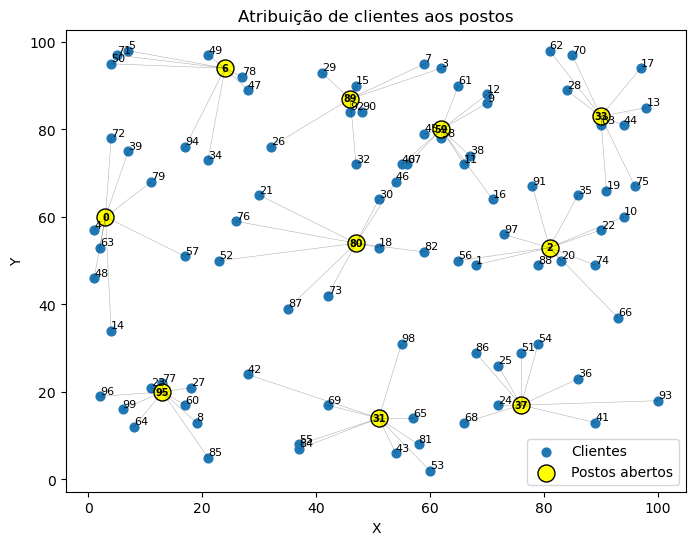




---Resolvendo instância 19---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Valor da função objetivo com a Solucao Inicial: 1532.0
Tamanho da vizinhança 0: 2
Tamanho da vizinhança 1: 109
Melhoria encontrada na vizinhança 1: Novo custo: 1389.0
Tamanho da vizinhança 0: 8
Melhoria encontrada na vizinhança 0: Novo custo: 1331.0
Tamanho da vizinhança 0: 8
Tamanho da vizinhança 1: 110
Melhoria encontrada na vizinhança 1: Novo custo: 1257.0
Tamanho da vizinhança 0: 12
Melhoria encontrada na vizinhança 0: Novo custo: 1237.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 112
Melhoria encontrada na vizinhança 1: Novo custo: 1143.0
Tamanho da vizinhança 0: 17
Melhoria encontrada na vizinhança 0: Novo custo: 1129.0
Tamanho da vizinhança 0: 18
Tamanho da vizinhança 1: 113
Melhoria encontrada na vizinhança 1: Novo custo: 1092.0
Tamanho da vizinhança 0: 22
Tamanho da vizinhança 1: 114
Melhoria encontrada na vizinhança 1: Novo custo: 1076.0
Tamanho da vizinhança 0: 22
Tamanho da vizinh

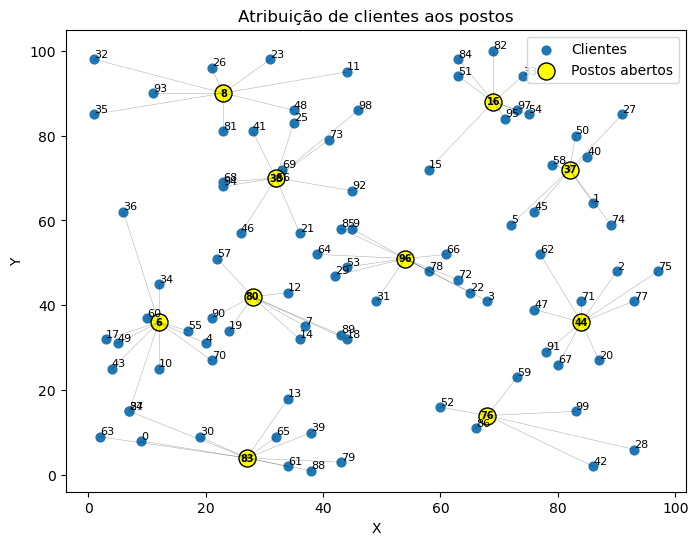




---Resolvendo instância 20---
Fornecedores inicial: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Valor da função objetivo com a Solucao Inicial: 2293.0
Tamanho da vizinhança 0: 2
Melhoria encontrada na vizinhança 0: Novo custo: 2278.0
Tamanho da vizinhança 0: 4
Melhoria encontrada na vizinhança 0: Novo custo: 1877.0
Tamanho da vizinhança 0: 5
Melhoria encontrada na vizinhança 0: Novo custo: 1855.0
Tamanho da vizinhança 0: 5
Tamanho da vizinhança 1: 105
Melhoria encontrada na vizinhança 1: Novo custo: 1677.0
Tamanho da vizinhança 0: 11
Melhoria encontrada na vizinhança 0: Novo custo: 1480.0
Tamanho da vizinhança 0: 10
Tamanho da vizinhança 1: 109
Melhoria encontrada na vizinhança 1: Novo custo: 1356.0
Tamanho da vizinhança 0: 13
Melhoria encontrada na vizinhança 0: Novo custo: 1289.0
Tamanho da vizinhança 0: 12
Tamanho da vizinhança 1: 107
Melhoria encontrada na vizinhança 1: Novo custo: 1250.0
Tamanho da vizinhança 0: 13
Tamanho da vizinhança 1: 109
Melhoria encontrada na vizinhança 1: Novo custo

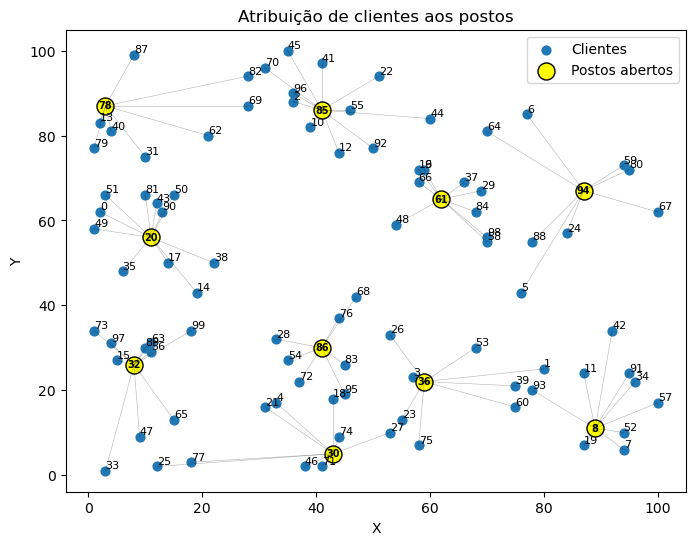

In [7]:
# resolvendo as instancias
solucoes = []
if __name__ == "__main__":
    arquivo = "Base de Dados/OR-Library/pmedcap1.txt"
    dados = ler_pmedcap1(arquivo)
    calcular_distancias(dados)

    print(f"Total de instâncias: {len(dados)}\n")

    solutions = []
    for i in range(0,20):
        print(f"---Resolvendo instância {i+1}---")

        melhor_valor = dados[i]["best_value"]     # melhor valor de solução 
        n = dados[i]["n"]                         # número de clientes
        p = dados[i]["p"]                         # número de medianas para abrir
        Q = dados[i]["Q"]                         # capacidade dos postos
        clientes = dados[i]["clientes"]           # dados dos clientes
        d = dados[i]["distancias"]                # matriz de distancias 
        q = [c["demanda"] for c in clientes]      # Vetor de demandas

        coordenada = coordenadas(dados[i])

        d = np.array(d)

        # ESTRATÉGIA GULOSA
        #start_time = time.time()
        s0 = metodo_guloso_capacitado(n, p, d, q, Q)
        #print(f"Tempo de execução Método Guloso: {time.time() - start_time:.2f} segundos")

        fornecedor_inicial = [j for j in range(n) if s0[j] > 0.5]
        print("Fornecedores inicial:", fornecedor_inicial)

        vizinhancas = [vizinhanca_v2, vizinhanca_v6, vizinhanca_v1, vizinhanca_v3]
        
        start_time = time.time()
        # s, f_s = VND(s0, vizinhancas, d, q, Q, n, n, p, coordenada)
        s, f_s, atribuicao = VND(s0, vizinhancas, d, q, Q, n, n, p, coordenada)
        execution_time = time.time() - start_time

        solucoes.append({
            'Custo': f_s,
            # 'Atribuição': atribuicao,
            'Execution Time': execution_time
        })
    
        print(f"Tempo de Execução: {execution_time:.2f} segundos")
        print(f"Instancia {i+1}: Custo mínimo total: {f_s:.1f}")
        fornecedores_abertos = [j for j in range(n) if s[j] > 0.5]
        print("Fornecedores abertos:", fornecedores_abertos)
        # plot_assignments_xy(s, atribuicao, clientes)
        plot_assignments_xy(s, atribuicao, clientes, nome_figura=f"inst{i+1}.png")
        print("\n\n")

In [20]:
solucao_vnd =     [713, 740, 751, 651, 672, 778, 789, 827, 715, 849, 1017, 986, 1026, 983, 1101, 955, 1040, 1046, 1046, 1022]
solucoes_otimas = [713, 740, 751, 651, 664, 778, 787, 820, 715, 829, 1006, 966, 1026, 982, 1091, 954, 1034, 1043, 1031, 1005]


for i in range(20):
    print(f"gap da instância pmed{i+1}: {(100*((solucao_vnd[i] - solucoes_otimas[i]) / solucoes_otimas[i])):.2f}")

gap da instância pmed1: 0.00
gap da instância pmed2: 0.00
gap da instância pmed3: 0.00
gap da instância pmed4: 0.00
gap da instância pmed5: 1.20
gap da instância pmed6: 0.00
gap da instância pmed7: 0.25
gap da instância pmed8: 0.85
gap da instância pmed9: 0.00
gap da instância pmed10: 2.41
gap da instância pmed11: 1.09
gap da instância pmed12: 2.07
gap da instância pmed13: 0.00
gap da instância pmed14: 0.10
gap da instância pmed15: 0.92
gap da instância pmed16: 0.10
gap da instância pmed17: 0.58
gap da instância pmed18: 0.29
gap da instância pmed19: 1.45
gap da instância pmed20: 1.69


In [ ]:
solucoes

In [7]:
solucoes_otimas = [713, 740, 751, 651, 664, 778, 787, 820, 715, 829, 1006, 966, 1026, 982, 1091, 954, 1034, 1043, 1031, 1005]
solucoes_iniciais = [850, 1719, 1247, 1198, 1286, 1222, 1096, 1275, 1044, 1340, 1915, 1426, 1790, 1610, 1838, 1640, 1869, 2054, 1552, 2279]
solucao_vnd = [713, 740, 759, 651, 664, 786, 817, 854, 719, 841, 1016, 971, 1026, 1012, 1099, 956, 1048, 1053, 1049,  1029]

for j, solucao in enumerate(solucoes):
    solucao_vnd.append(solucao['Custo'])

for i in range(20):
    print(f"gap da instância pmed{i+1}: {(100*((solucoes_iniciais[i] - solucoes_otimas[i]) / solucoes_otimas[i])):.2f}")

print("\n")

for i in range(20):
    print(f"gap da instância pmed{i+1}: {(100*((solucao_vnd[i] - solucoes_otimas[i]) / solucoes_otimas[i])):.2f}")

gap da instância pmed1: 19.21
gap da instância pmed2: 132.30
gap da instância pmed3: 66.05
gap da instância pmed4: 84.02
gap da instância pmed5: 93.67
gap da instância pmed6: 57.07
gap da instância pmed7: 39.26
gap da instância pmed8: 55.49
gap da instância pmed9: 46.01
gap da instância pmed10: 61.64
gap da instância pmed11: 90.36
gap da instância pmed12: 47.62
gap da instância pmed13: 74.46
gap da instância pmed14: 63.95
gap da instância pmed15: 68.47
gap da instância pmed16: 71.91
gap da instância pmed17: 80.75
gap da instância pmed18: 96.93
gap da instância pmed19: 50.53
gap da instância pmed20: 126.77


gap da instância pmed1: 0.00
gap da instância pmed2: 0.00
gap da instância pmed3: 1.07
gap da instância pmed4: 0.00
gap da instância pmed5: 0.00
gap da instância pmed6: 1.03
gap da instância pmed7: 3.81
gap da instância pmed8: 4.15
gap da instância pmed9: 0.56
gap da instância pmed10: 1.45
gap da instância pmed11: 0.99
gap da instância pmed12: 0.52
gap da instância pmed13: 0.00
gap 

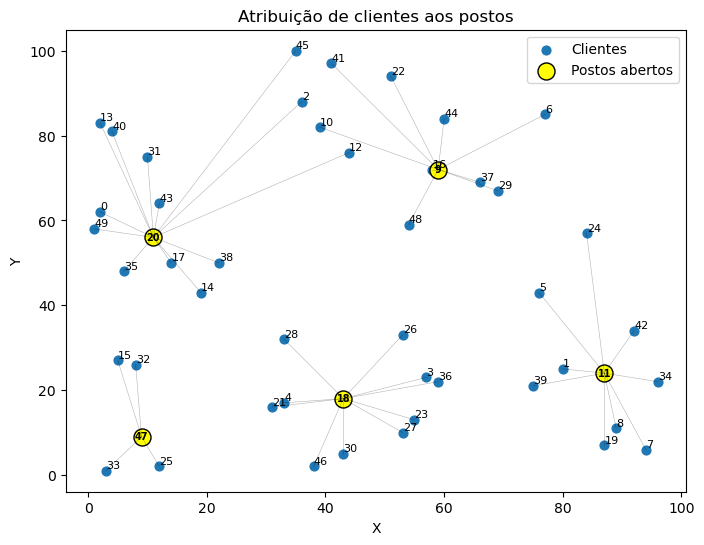

In [21]:
def plot_assignments_xy(s, atribuicao, clientes):
    """
    s = vetor binário indicando quais postos estão abertos
    atribuicao[i] = posto j que atende o cliente i
    clientes = lista com {'x', 'y', 'demanda'}
    """

    x = [c["x"] for c in clientes]
    y = [c["y"] for c in clientes]

    postos_abertos = [j for j in range(len(s)) if s[j] > 0.5]

    plt.figure(figsize=(8, 6))

    # Plot clientes
    plt.scatter(x, y, marker='o', s=40, label="Clientes")

    # Nome dos clientes (exceto os postos) ao lado do ponto
    for i in range(len(clientes)):
        if i not in postos_abertos:
            plt.text(x[i] + 0.02, y[i] + 0.02,
                     str(i),
                     fontsize=8, color="black",
                     ha='left', va='bottom')

    # Plot postos abertos
    plt.scatter([x[j] for j in postos_abertos],
                [y[j] for j in postos_abertos],
                marker='o', s=150, edgecolors='black',
                facecolors='yellow', label="Postos abertos")

    # Escrever número do posto DENTRO do quadrado
    for j in postos_abertos:
        plt.text(x[j], y[j], str(j),
                 fontsize=7, color="black",
                 fontweight='bold',
                 ha='center', va='center')

    # Conexões cliente → posto
    for i, j in enumerate(atribuicao):
        if j != -1 and s[j] > 0.5:
            plt.plot([x[i], x[j]], [y[i], y[j]], color="black", linewidth=0.4, alpha=0.3)

    plt.title("Atribuição de clientes aos postos")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    #plt.grid(alpha=0.3)
    plt.show()


plot_assignments_xy(s, atribuicao, clientes)
# atribuicao, ok = atribuir_clientes_capacitado(s, d, q, Q)

# if ok:
#     plot_assignments_xy(s, atribuicao, clientes)
# else:
#     print("Não foi possível alocar todos os clientes.")

In [20]:
gurobi = [1.33, 0.41, 0.66, 0.38, 1.32, 0.80, 0.97, 2.34, 0.95, 2.16, 7.45, 10.40, 4.94, 12.17, 11.85, 4.47, 10.71, 9.77, 7.49, 198.44]

vnd = [3.17, 3.54, 5.60, 3.43, 2.84, 5.49, 3.59, 7.34, 4.74, 2.95, 151.93, 61.42, 34.08, 61.58, 94.17, 61.40, 63.07, 33.49, 35.00, 62.50]

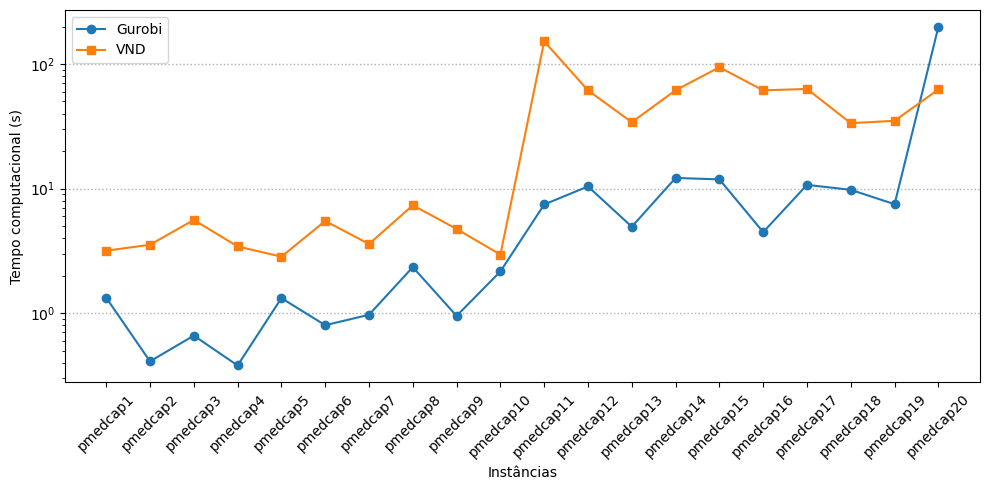

In [22]:
instances = [f"pmedcap{i}" for i in range(1, 21)]

plt.figure(figsize=(10, 5))
plt.plot(instances, gurobi, marker='o', label='Gurobi')
plt.plot(instances, vnd, marker='s', label='VND')

# Escala logarítmica
plt.yscale("log")

# Grid horizontal pontilhado apenas em 10^0, 10^1, 10^2
plt.yticks([1, 10, 100])
plt.grid(axis='y', which='major', linestyle=':', linewidth=1)

plt.xlabel("Instâncias")
plt.ylabel("Tempo computacional (s)")
# plt.title("Comparação do Tempo Computacional")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("grafico_com_capacidade.png", dpi=300, bbox_inches="tight")
plt.show()

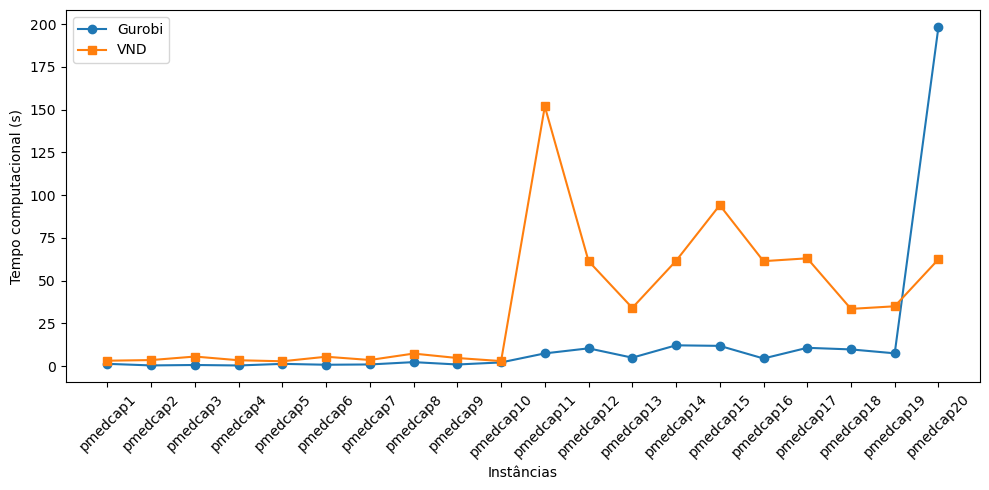

In [12]:
instances = [f"pmedcap{i}" for i in range(1, 21)]

plt.figure(figsize=(10, 5))
plt.plot(instances, gurobi, marker='o', label='Gurobi')
plt.plot(instances, vnd, marker='s', label='VND')

# Escala logarítmica
# plt.yscale("log")

plt.xlabel("Instâncias")
plt.ylabel("Tempo computacional (s)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# plt.savefig("grafico_com_capacidade.png", dpi=300, bbox_inches="tight")

plt.show()